### Package loading

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from random import seed
plt.style.use("seaborn")

from warnings import filterwarnings

filterwarnings("ignore")

seed(0)

/tmp/ipykernel_7873/1520679316.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


### Loading data

In [2]:
clust_data=pd.read_excel("Online Retail.xlsx")

In [3]:
clust_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Feature engineering

In [4]:
clust_data["Order_price"]=clust_data["Quantity"]*clust_data["UnitPrice"]
clust_data["Order_status"]=["Done" if order_price>0 else "Cancelled" for order_price in clust_data["Order_price"]]
clust_data["Year"]=clust_data["InvoiceDate"].dt.year
clust_data["Month"]=clust_data["InvoiceDate"].dt.month
clust_data["Day"]=clust_data["InvoiceDate"].dt.day
clust_data["Hour"]=clust_data["InvoiceDate"].dt.hour
clust_data["Minute"]=clust_data["InvoiceDate"].dt.minute

### Data wrangling

In [5]:
## How many not defined data per columns

clust_data.isna().sum()

InvoiceNo            0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
Order_price          0
Order_status         0
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
dtype: int64

In [6]:
clust_data[clust_data["Order_status"]=="Cancelled"].isna().sum()

InvoiceNo          0
StockCode          0
Description     1454
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID      2860
Country            0
Order_price        0
Order_status       0
Year               0
Month              0
Day                0
Hour               0
Minute             0
dtype: int64

For orders without `Description` label have all 0.0 as `UnitPrice` then it is difficult to track these product and at the same time we haven't `CustomerID`. Then these rows can't be useful for this clutering, subquently we will drop then from our data.

In [7]:
clust_data=clust_data[clust_data["Description"].notna()]
clust_data["CustomerID"]=clust_data["CustomerID"].astype("object")

In [8]:
cancelled=clust_data[clust_data["Order_status"]=="Cancelled"]
Done=clust_data[clust_data["Order_status"]=="Done"]

Some values of UnitPrice are not acceptable like 0.00 and also the max values that have the same problem of description name. For data quality we have to keep out these views from our data.

In [9]:
clust_data=clust_data[clust_data["UnitPrice"]!=0.0]
clust_data=clust_data[clust_data["UnitPrice"]!=clust_data["UnitPrice"].max()]

### Data description

In [10]:
### Data description

clust_data[["Quantity","UnitPrice","Order_price"]].describe()

,Quantity,UnitPrice,Order_price
count,539393.000000,539393.000000,539393.000000
mean,9.845892,4.560374,18.143947
std,215.412452,81.186206,375.961898
min,-80995.000000,-11062.060000,-168469.600000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.840000
75%,10.000000,4.130000,17.400000
max,80995.000000,17836.460000,168469.600000


- We have `std` high than `mean` for both variables Quantity and UnitPrice.Then we have a high varaiance in our data that can be explain by pareto law as 20% of customers create 80% turnover. And also the products have a significant difference in price.

- As mentionned in InvoiceNo we have some orders cancelled, the most high number of items order cancelled is 80995 with 168469 `Money Unit`.

- Finally our data is very skewed as we can noticed with std>mean, that can lead by considering some observation as outliers.

In [11]:
clust_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Order_price,Order_status,Year,Month,Day,Hour,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Done,2010,12,1,8,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Done,2010,12,1,8,26


In [12]:
cancelled[cancelled['Order_price']<0].shape

(9290, 15)

In [13]:
### We will drop orders that where cancelled after ordering. Then we will keep only effective order for
### our clustering

"""Usefulness=[]
for order_price in cancelled["Order_price"]:

    if -1*order_price in Done["Order_price"]:

        Usefulness.append("Yes")

    else:

        Usefulness.append("No")
    
cancelled["Usefulness"]=Usefulness"""


Usefulness_done=[]


for order_price in Done["Order_price"]:

    if order_price in -1*cancelled["Order_price"]:

        Usefulness_done.append("Yes")

    else:

        Usefulness_done.append("No")
    
Done["Usefulness"]=Usefulness_done

In [14]:
from collections import Counter

Counter(Usefulness_done)

Counter({'No': 530071, 'Yes': 33})

In [15]:
Done=Done[Done["Usefulness"]=="No"].drop(columns="Usefulness")

In [16]:
clust_data_=Done

### Check for dupplicated data

In [17]:
clust_data_=clust_data_.drop(columns=["CustomerID",'StockCode','InvoiceNo','InvoiceDate',"Year"])

In [18]:
clust_data_.duplicated().sum()

6055

### Cleaned data

In [19]:
cleaned_clust_data=clust_data_.drop_duplicates()

In [20]:
cleaned_clust_data.shape

(524016, 10)

### Exploration

In [21]:
figsize=(14,6)

def annotate_stacked_bars(fig):

    plt.rcParams.update({'font.size':15})
    total=cleaned_clust_data.shape[0]
    for p in fig.patches:

        if p.get_height()!=0:
            height = p.get_height()
            fig.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2%}'.format(height/total),
                    ha="center") 
    plt.show()

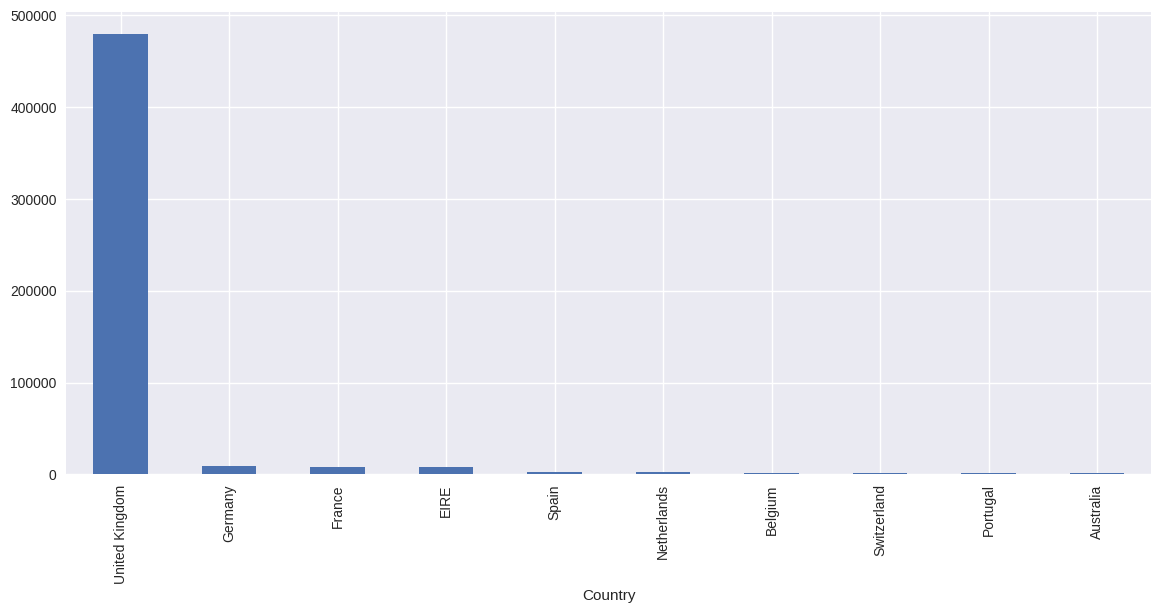

In [22]:
order_per_country=cleaned_clust_data.groupby("Country").count().sort_values(by="Description",ascending=False)

fig=order_per_country["Description"].iloc[:10].plot(kind="bar",figsize=figsize)

<AxesSubplot: xlabel='Description'>

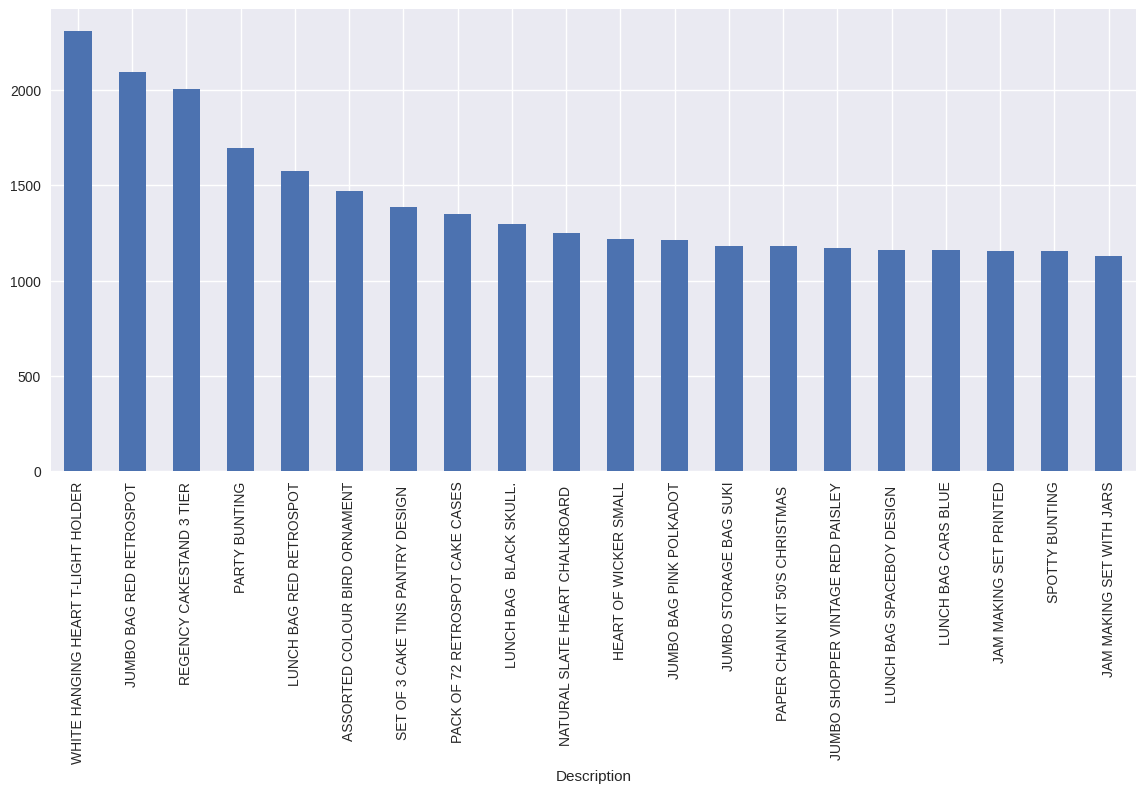

In [23]:
order_per_product=cleaned_clust_data.groupby("Description").count().sort_values(by="Country",ascending=False)

order_per_product["Country"].iloc[:20].plot(kind="bar",figsize=figsize)

Some products are most popular like `WHITE HANGING HEART T-LIGHT HOLDER` but with UnitPrice 2.95

<AxesSubplot: xlabel='Month'>

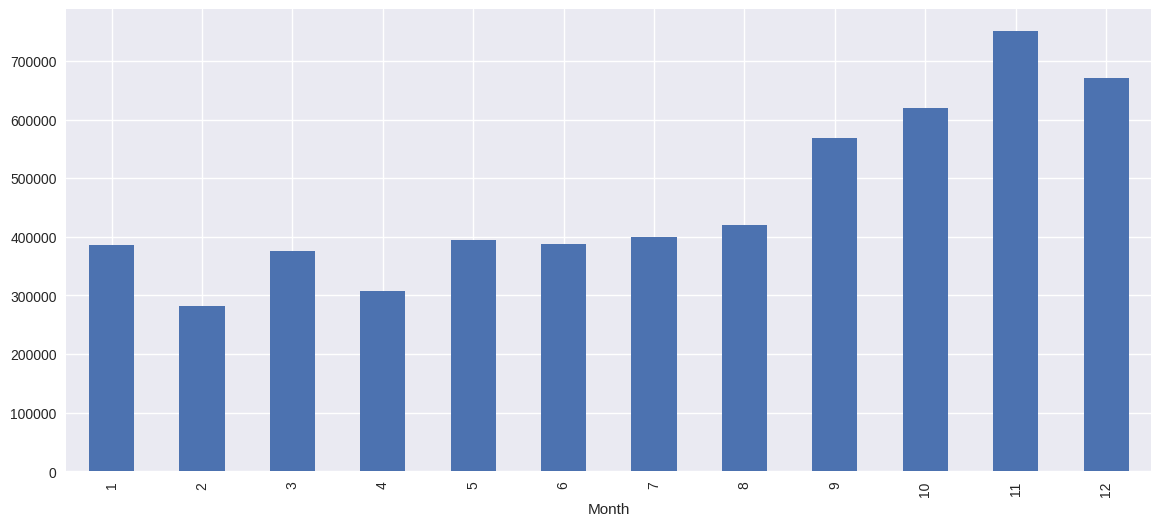

In [24]:
cleaned_clust_data.groupby("Month").sum()["Quantity"].plot(kind="bar",figsize=figsize)

<AxesSubplot: xlabel='Day'>

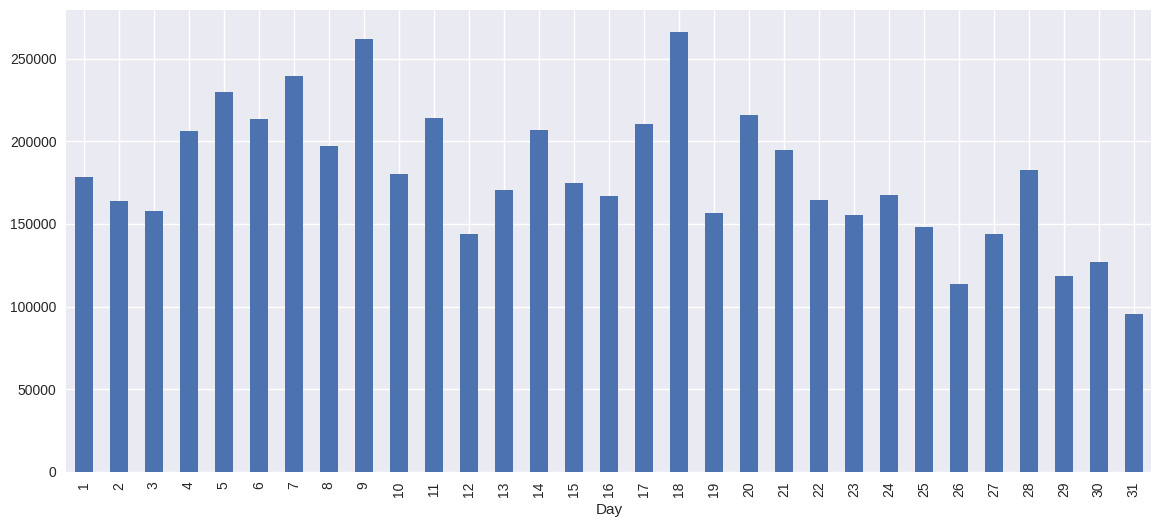

In [25]:
cleaned_clust_data.groupby("Day").sum()["Quantity"].plot(kind="bar",figsize=figsize)

<AxesSubplot: xlabel='Hour'>

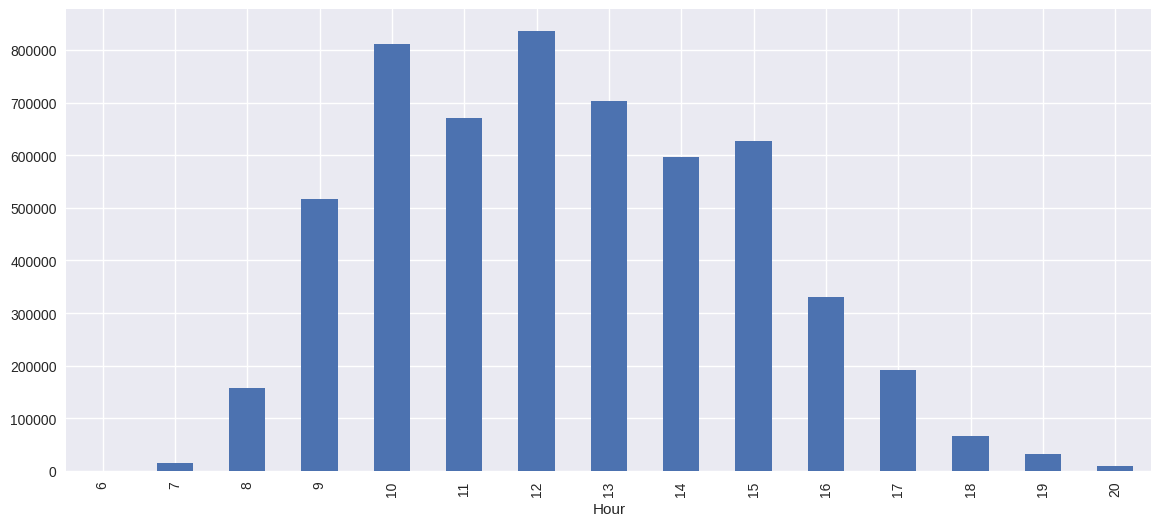

In [26]:
cleaned_clust_data.groupby("Hour").sum()["Quantity"].plot(kind="bar",figsize=figsize)

<AxesSubplot: xlabel='Minute'>

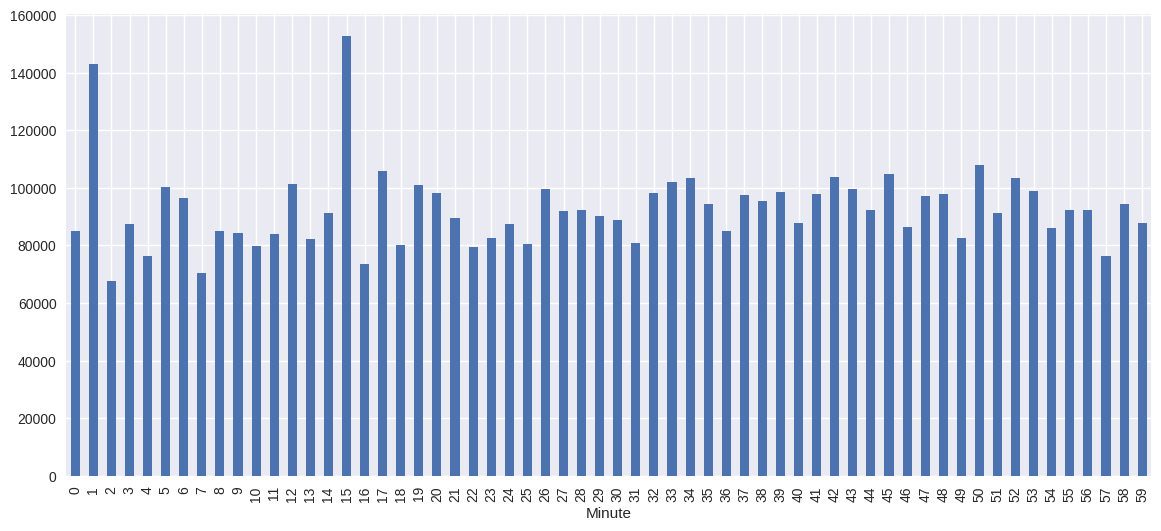

In [27]:
cleaned_clust_data.groupby("Minute").sum()["Quantity"].plot(kind="bar",figsize=figsize)

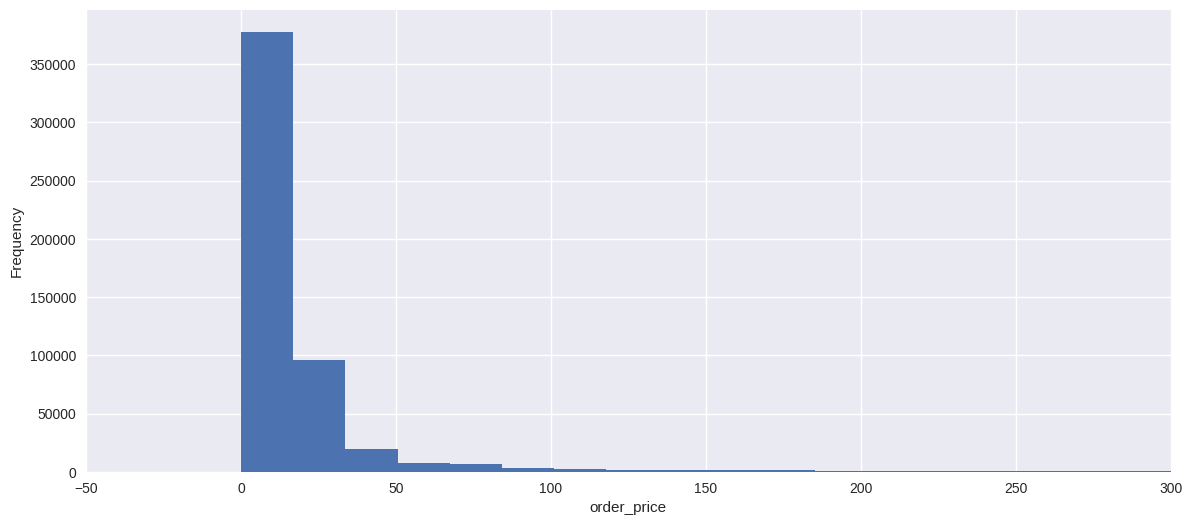

In [28]:
cleaned_clust_data["Order_price"].sort_values().plot(kind="hist",bins=10000,figsize=figsize)
plt.xlim(-50,300)
plt.xlabel("order_price")
plt.show()

`Order_price` is right skeweed, the most order prices is between 0 and 50. To solve this problem of skewness we will use boxcox transformation.

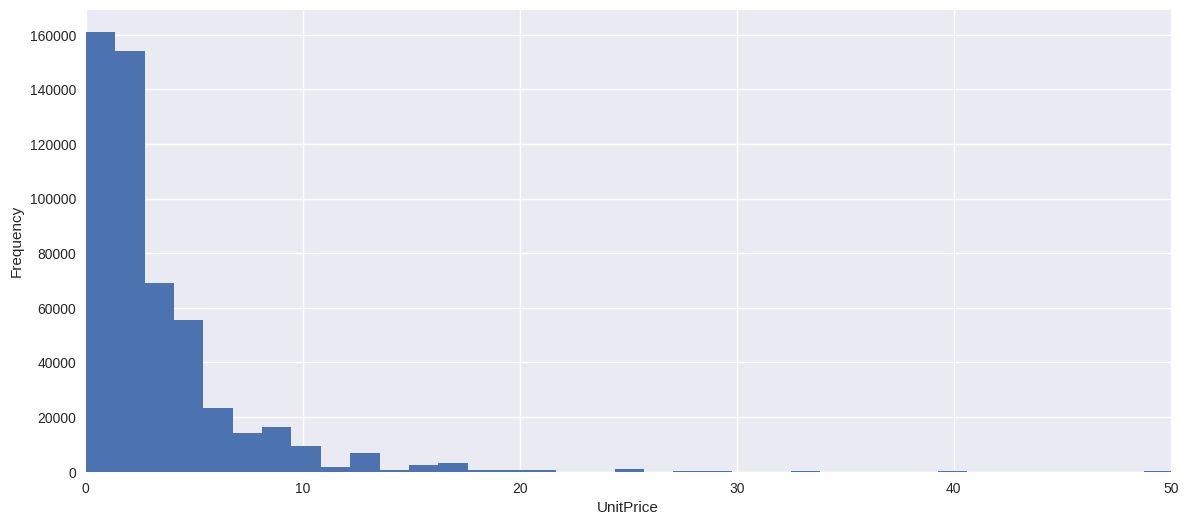

In [29]:
cleaned_clust_data["UnitPrice"].sort_values().plot(kind="hist",bins=10000,figsize=figsize)
plt.xlim(0,50)
plt.xlabel("UnitPrice")
plt.show()

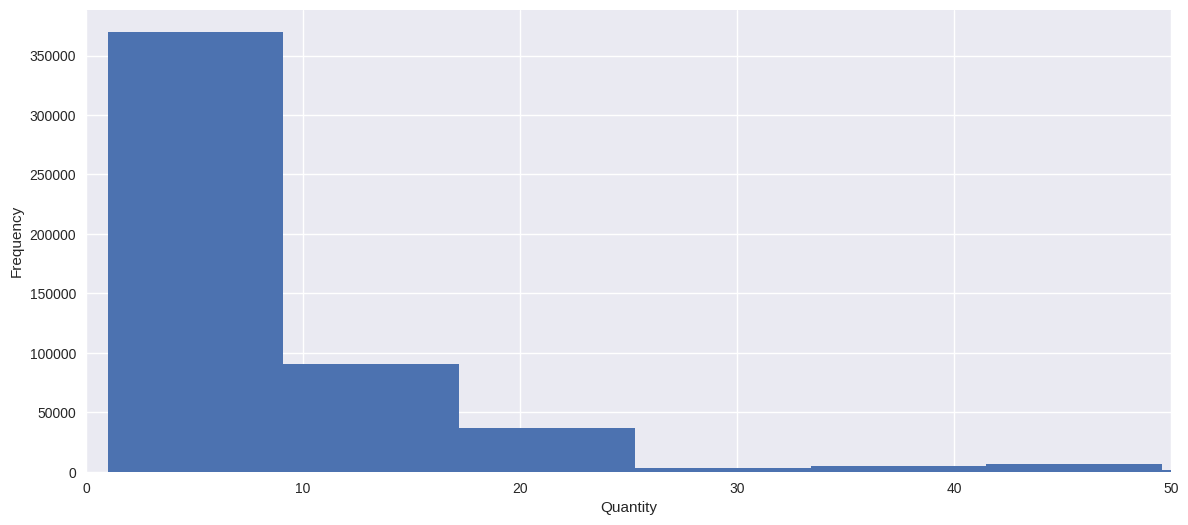

In [30]:
cleaned_clust_data["Quantity"].plot(kind="hist",bins=10000,figsize=figsize)
plt.xlim(0,50)
plt.xlabel("Quantity")
plt.show()

In [31]:
cleaned_clust_data.head()

,Description,Quantity,UnitPrice,Country,Order_price,Order_status,Month,Day,Hour,Minute
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,Done,12,1,8,26
1,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,Done,12,1,8,26
2,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,Done,12,1,8,26
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,Done,12,1,8,26
4,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,Done,12,1,8,26


### Boxcox transformation

In [32]:
import numpy as np

def get_best_lmbda(df,col,number_of_lmbda):
    
    """
    This function take take as inputs:
    df: dataframe
    col: a col to transform
    number_of_lmbda: a value for box_cox function to transform col
    
    return:
            return the best lmbda value to get the low skewness of col. And allow 
            to get a new col that follow Gaussian ditribution
    """

    lmbda_values=[]

    skeweness_values=[]

    for lmbda in np.linspace(-1,1,number_of_lmbda):
        
        col_trans=stats.boxcox(df[col],lmbda=lmbda)

        skeweness_values.append(np.abs(stats.skew(col_trans)))

        lmbda_values.append(lmbda)

    plt.plot(lmbda_values,skeweness_values)
    
    plt.ylabel("skewness")
    
    plt.xlabel("lmbda_values")
    
    plt.show()
    
    lmbda_optimal=lmbda_values[skeweness_values.index(min(skeweness_values))]

    print(f"Optimal value of lmbda est:{lmbda_optimal}")

    return lmbda_optimal


def solve_skewness(df,col,lmbda=0.0):

    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,6))

    df[col+'_trans']=stats.boxcox(df[col],lmbda=lmbda)

    ax[0].hist(df[col])
    ax[1].hist(df[col+'_trans'])

    ax[0].set_title("Orginal data")
    ax[1].set_title("Transformed data")
    ax[0].set_xlabel(col)
    ax[1].set_xlabel(col+'_trans')

    plt.show()

    return df

def normalize_num_cols(df,scaler):

    df_standard=df.copy()

    standardizing=scaler()
    number_data=df.select_dtypes(include="number")
    numerical_cols=number_data.columns[number_data.nunique()>2]

    standar_col_num=standardizing.fit_transform(df[numerical_cols])

    df_standard[numerical_cols]=standar_col_num

    return df_standard

In [33]:
def transform_data(df,to_transform_cols):

    for col in to_transform_cols:

        lmbda_optimal=get_best_lmbda(df,col,100)
        df=solve_skewness(df,col,lmbda=lmbda_optimal)

In [34]:
to_transform=["UnitPrice","Order_price"]

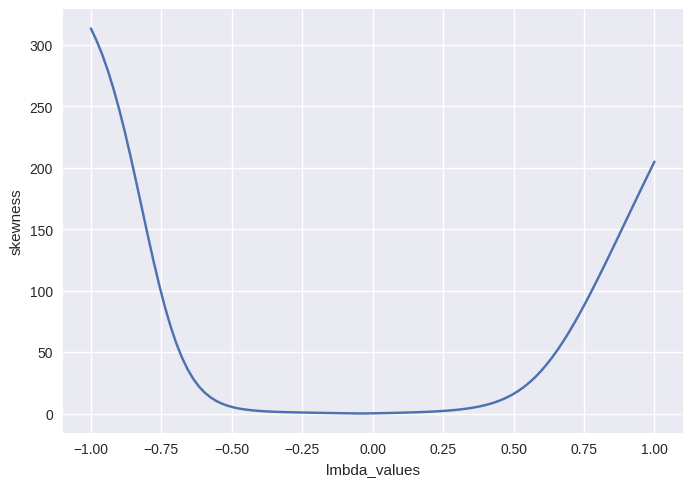

Optimal value of lmbda est:-0.030303030303030276


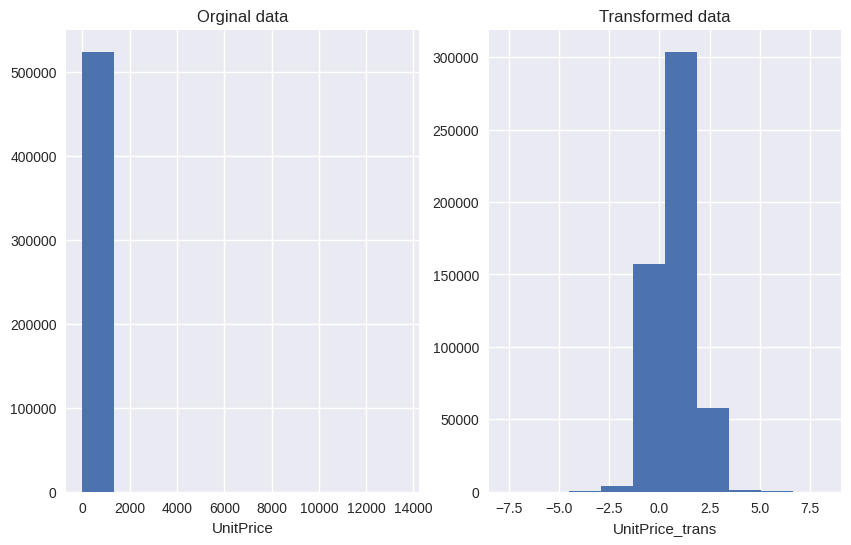

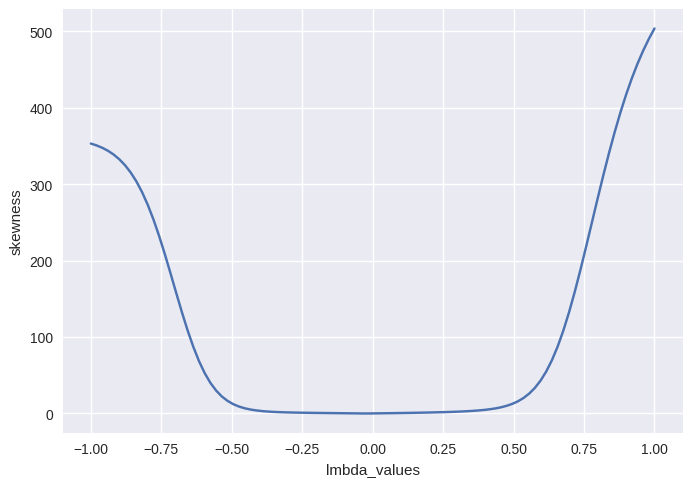

Optimal value of lmbda est:-0.030303030303030276


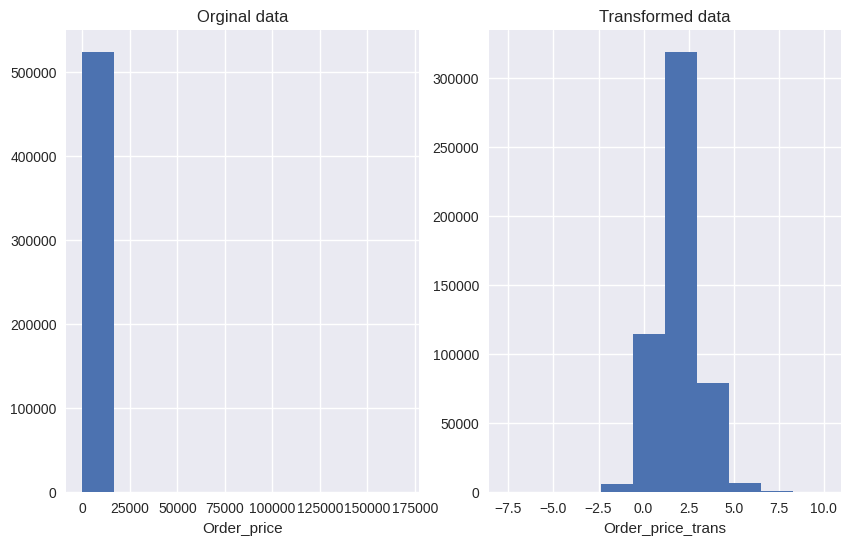

In [35]:
transform_data(cleaned_clust_data,to_transform)

In [36]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [37]:
cleaned_clust_data_stan=normalize_num_cols(cleaned_clust_data,scaler=StandardScaler)

In [38]:
cleaned_clust_data_stan.head()

,Description,Quantity,UnitPrice,Country,Order_price,Order_status,Month,Day,Hour,Minute,UnitPrice_trans,Order_price_trans
0,WHITE HANGING HEART T-LIGHT HOLDER,-0.029534,-0.037920,United Kingdom,-0.018295,Done,1.267427,-1.618946,-2.076519,-0.236896,0.188945,0.492403
1,WHITE METAL LANTERN,-0.029534,-0.014663,United Kingdom,0.000242,Done,1.267427,-1.618946,-2.076519,-0.236896,0.485375,0.727386
2,CREAM CUPID HEARTS COAT HANGER,-0.016746,-0.032383,United Kingdom,0.006347,Done,1.267427,-1.618946,-2.076519,-0.236896,0.267803,0.791775
3,KNITTED UNION FLAG HOT WATER BOTTLE,-0.029534,-0.014663,United Kingdom,0.000242,Done,1.267427,-1.618946,-2.076519,-0.236896,0.485375,0.727386
4,RED WOOLLY HOTTIE WHITE HEART.,-0.029534,-0.014663,United Kingdom,0.000242,Done,1.267427,-1.618946,-2.076519,-0.236896,0.485375,0.727386


In [39]:
cleaned_clust_data_stan=cleaned_clust_data_stan.drop(columns=["Order_status"])

In [40]:
cleaned_clust_data_stan.to_csv("cleaned_clust_data_stan.csv",index=False)

In [41]:
cleaned_clust_data_stan.shape

(524016, 11)

In [42]:
cleaned_clust_data_stan["Description"].nunique(),cleaned_clust_data_stan["Country"].nunique()

(4026, 38)

In [43]:
cleaned_clust_data_stan=cleaned_clust_data_stan.drop(columns=["Description"])

In [44]:
cleaned_clust_data_stan=pd.get_dummies(cleaned_clust_data_stan)

In [45]:
cleaned_clust_data_stan.head()

,Quantity,UnitPrice,Order_price,Month,Day,Hour,Minute,UnitPrice_trans,Order_price_trans,Country_Australia,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,-0.029534,-0.037920,-0.018295,1.267427,-1.618946,-2.076519,-0.236896,0.188945,0.492403,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.029534,-0.014663,0.000242,1.267427,-1.618946,-2.076519,-0.236896,0.485375,0.727386,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.016746,-0.032383,0.006347,1.267427,-1.618946,-2.076519,-0.236896,0.267803,0.791775,0,...,0,0,0,0,0,0,0,0,1,0
3,-0.029534,-0.014663,0.000242,1.267427,-1.618946,-2.076519,-0.236896,0.485375,0.727386,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.029534,-0.014663,0.000242,1.267427,-1.618946,-2.076519,-0.236896,0.485375,0.727386,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
cleaned_clust_data_stan.to_csv("cleaned_and_coded_data.csv",index=False)